- Book: Modern Computer Vision with PyTorch (by V Kishore Ayyadevara)

In [238]:
!pip install torch_summary
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 40.1 MB/s eta 0:00:00


In [243]:
# Libraries
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
from torchvision import datasets
from torchsummary import summary
import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

In [188]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [189]:
x_train = torch.tensor([[[[1, 2, 3, 4], [2, 3, 4, 5], [5, 6, 7, 8], 
                          [1, 3, 4, 5]]], [[[-1, 2, 3, -4], [2, -3, 4, 5],
                                            [-5, 6, -7, 8], 
                                            [-1, -3, -4, -5]]]]).to(device).float()
# Scaling the input dataset so that it has a range between -1 to +1
# by dividing the input data by the maximum input value (8)
x_train /= 8
y_train = torch.tensor([0, 1]).to(device).float()

In [190]:
x_train

tensor([[[[ 0.1250,  0.2500,  0.3750,  0.5000],
          [ 0.2500,  0.3750,  0.5000,  0.6250],
          [ 0.6250,  0.7500,  0.8750,  1.0000],
          [ 0.1250,  0.3750,  0.5000,  0.6250]]],


        [[[-0.1250,  0.2500,  0.3750, -0.5000],
          [ 0.2500, -0.3750,  0.5000,  0.6250],
          [-0.6250,  0.7500, -0.8750,  1.0000],
          [-0.1250, -0.3750, -0.5000, -0.6250]]]], device='cuda:0')

- PyTorch expects inputs to be of the shape **N x C x H x W**
- N: Batch Size (number of images)
- C: Number of Channels (filters)
- H: Height
- W: Width

<br>

- The shape of this input data is (2, 1, 4, 4)

In [191]:
x_train.shape

torch.Size([2, 1, 4, 4])

## Model Architecture

In [192]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=3), # 1 filter with a size of 3x3
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1, 1),
        nn.Sigmoid()
    )
    loss = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss, optimizer

In [193]:
model, loss, optimizer = get_model()
summary(model, x_train)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

- Conv2d has 9 weights (3x3 kernel) and 1 bias (1 kernel)
- Linear has 1 node, 1 weight and 1 bias

In [194]:
def train_batch(x, y, model, opt, loss):
    model.train()
    prediction = model(x)
    batch_loss = loss(prediction.squeeze(0), y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [195]:
trn_dl = DataLoader(TensorDataset(x_train, y_train))

In [196]:
for ix, batch in enumerate(iter(trn_dl)):
    print(ix)
    print(batch)

0
[tensor([[[[0.1250, 0.2500, 0.3750, 0.5000],
          [0.2500, 0.3750, 0.5000, 0.6250],
          [0.6250, 0.7500, 0.8750, 1.0000],
          [0.1250, 0.3750, 0.5000, 0.6250]]]], device='cuda:0'), tensor([0.], device='cuda:0')]
1
[tensor([[[[-0.1250,  0.2500,  0.3750, -0.5000],
          [ 0.2500, -0.3750,  0.5000,  0.6250],
          [-0.6250,  0.7500, -0.8750,  1.0000],
          [-0.1250, -0.3750, -0.5000, -0.6250]]]], device='cuda:0'), tensor([1.], device='cuda:0')]


In [197]:
for epoch in range(2000):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss)

In [198]:
model(x_train[:1])

tensor([[0.0047]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [199]:
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

# Classifying Images - Fashion MNIST

In [200]:
data_folder = '/content/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [201]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [202]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 1, 28, 28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [203]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),     # 128 * 25 = 3200
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss, optimizer

In [204]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [205]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [206]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss(prediction, y)
    return val_loss.item()

In [207]:
trn_dl, val_dl = get_data()

In [208]:
model, loss, optimizer = get_model()
summary(model, torch.zeros(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

- Layer 1: 64 filters with a kernel of 3x3, 64 * 3 * 3 weights + 64 bias
- Layer 4: 128 filters x 64 filters x 3x3 weights + 128 bias
- Layer 8: 3200 nodes connected with 256 nodes = 3200 * 256 weights + 256 bias
- Layer 10: 256 nodes connected with 10 nodes = 256 * 10 weights + 10 bias

## Training

In [209]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


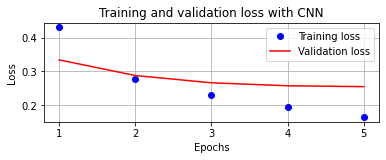

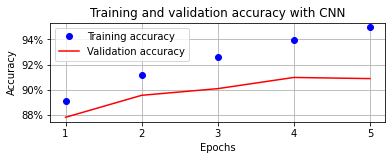

In [210]:
epochs = np.arange(5)+1
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Translating the Image Between -5 pixels to +5 pixels and Prediction

In [211]:
tr_images[24300]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 190, 198, 178, 183,
         182, 186, 184, 180, 188, 181,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   8, 253, 216, 210, 223,
         210, 194, 209, 204, 198, 223,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  64, 220, 205, 205, 219,
         214, 205, 208, 189, 191, 219,  16,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 122, 204, 205, 223, 214,
         215, 190, 214, 213, 198, 213,  87,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 174, 203, 203, 204, 201,
         212, 198, 201, 213, 182, 202, 137,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 222, 208, 199, 198, 222,
         211, 208, 230, 211, 197, 206, 149,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

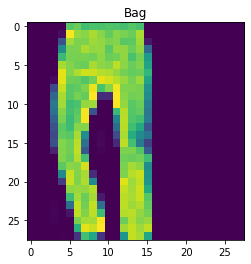

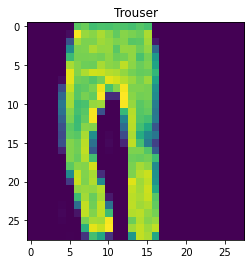

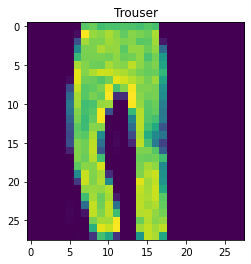

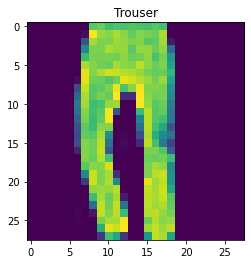

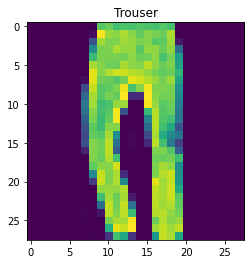

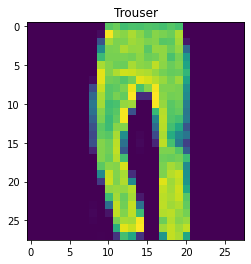

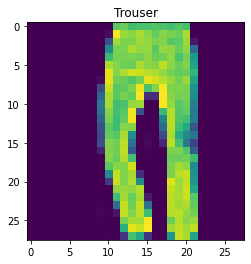

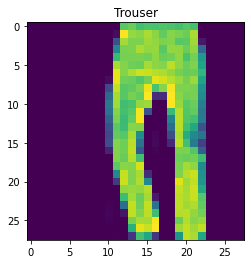

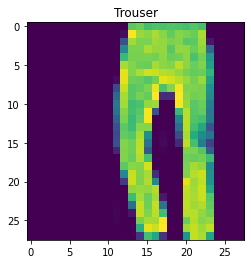

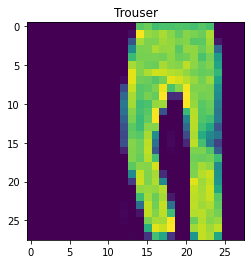

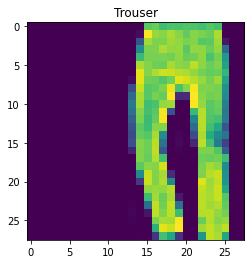

In [212]:
preds = []
ix = 24300
for px in range(-5, 6):
    img = tr_images[ix] / 255
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.tensor(img2).view(-1, 1, 28, 28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output) / np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

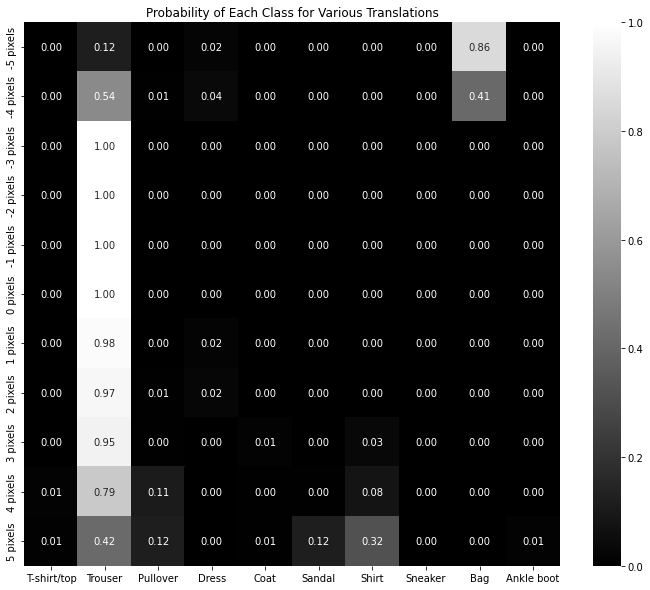

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.title('Probability of Each Class for Various Translations')
sns.heatmap(np.array(preds).reshape(11, 10), annot=True,
            ax=ax, fmt='.2f', xticklabels=fmnist.classes,
            yticklabels=[str(i) + str(' pixels') for i in range(-5, 6)],
            cmap='gray')

## Image Augmentation

In [214]:
!pip install -U imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [215]:
from imgaug import augmenters as iaa

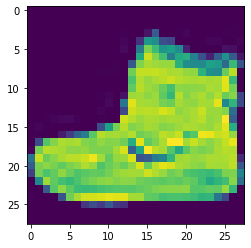

In [216]:
plt.imshow(tr_images[0])

In [217]:
test_image = tr_images[0].cpu().detach().numpy()

Text(0.5, 1.0, 'Scaled Image')

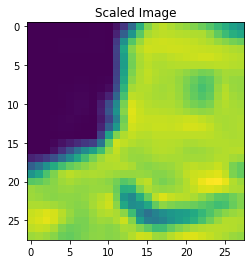

In [218]:
# Defining a object that performs scalling
aug = iaa.Affine(scale=2)
# Specify augmentation
plt.imshow(aug.augment_image(test_image))
plt.title('Scaled Image')

Text(0.5, 1.0, 'Translated Image by 10 Pixels')

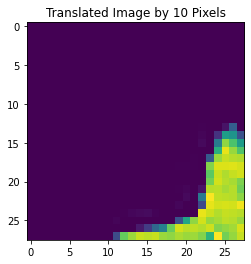

In [219]:
# Translate the image
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(test_image))
plt.title('Translated Image by 10 Pixels')

Text(0.5, 1.0, 'Translation of 5 pixels across \n columns and 2 pixels over rows')

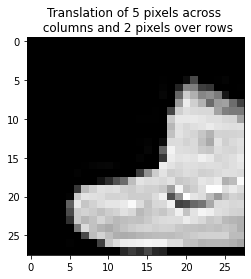

In [220]:
# Translate the image more in one axis and less in the other
aug = iaa.Affine(translate_px={'x': 5, 'y': 2})
plt.imshow(aug.augment_image(test_image), cmap='gray')
plt.title('Translation of 5 pixels across \n columns and 2 pixels over rows')

Text(0.5, 1.0, 'Rotation of Image by -30 degrees')

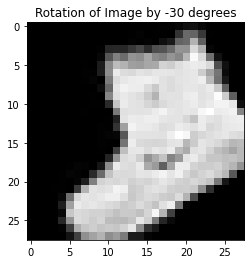

In [221]:
# Rotate the Image
aug = iaa.Affine(rotate=-30)
plt.imshow(aug.augment_image(test_image), cmap='gray')
plt.title('Rotation of Image by -30 degrees')

- Translation and Rotation loses information, because the image gets cropped

### Fixing Cropped Images

Text(0.5, 1.0, 'Rotation of Image by -30 degrees with fit_output')

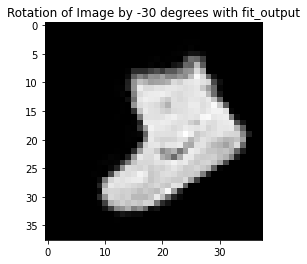

In [222]:
aug = iaa.Affine(rotate=-30, fit_output=True)
plt.imshow(aug.augment_image(test_image), cmap='gray')
plt.title('Rotation of Image by -30 degrees with fit_output')

- Getting to know how the new pixels that are not part of the original image are filled in

Text(0.5, 1.0, 'Rotation of Image by -30 degrees with fit_output')

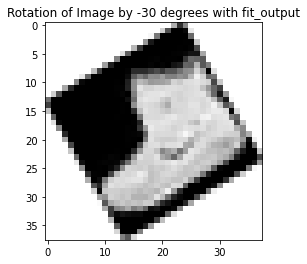

In [223]:
aug = iaa.Affine(rotate=-30, fit_output=True, cval=255)
plt.imshow(aug.augment_image(test_image), cmap='gray')
plt.title('Rotation of Image by -30 degrees with fit_output')

### Image Brightness

Text(0.5, 1.0, 'Pixels multiplied by 0.5')

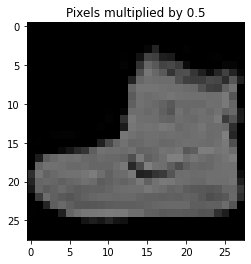

In [224]:
aug = iaa.Multiply(0.5)
plt.imshow(aug.augment_image(test_image), cmap='gray', vmin = 0, vmax = 255)
plt.title('Pixels multiplied by 0.5')

Text(0.5, 1.0, 'Pixels contrast by 0.5')

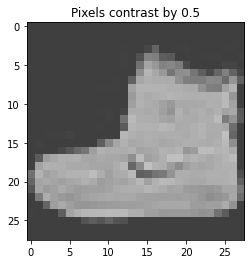

In [225]:
aug = iaa.LinearContrast(0.5)
plt.imshow(aug.augment_image(test_image), cmap='gray', vmin = 0, vmax = 255)
plt.title('Pixels contrast by 0.5')

### Blur

Text(0.5, 1.0, 'Gaussian Blurring of Image')

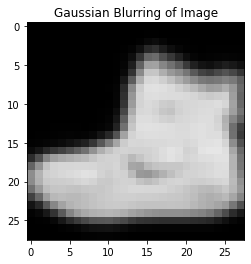

In [226]:
aug = iaa.GaussianBlur(sigma=0.8)
plt.imshow(aug.augment_image(test_image), cmap='gray', vmin = 0, vmax = 255)
plt.title('Gaussian Blurring of Image')

### Adding Noise

Text(0.5, 1.0, 'Random 20% Salt and Pepper Noise')

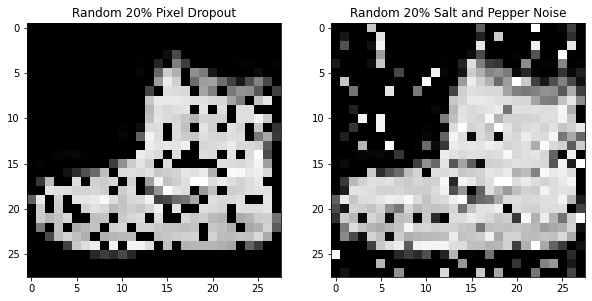

In [227]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
aug = iaa.Dropout(p = 0.2)
plt.imshow(aug.augment_image(test_image), cmap='gray', vmin = 0, vmax = 255)
plt.title('Random 20% Pixel Dropout')
plt.subplot(1, 2, 2)
aug = iaa.SaltAndPepper(0.2)
plt.imshow(aug.augment_image(test_image), cmap='gray', vmin = 0, vmax = 255)
plt.title('Random 20% Salt and Pepper Noise')

### Sequence of Augmentations

In [228]:
seq = iaa.Sequential([
    iaa.Dropout(p = 0.2),
    iaa.Affine(rotate = (-30, 30))], random_order = True)

Text(0.5, 1.0, 'Image Augmented using a Random Order of the Two Augmentations')

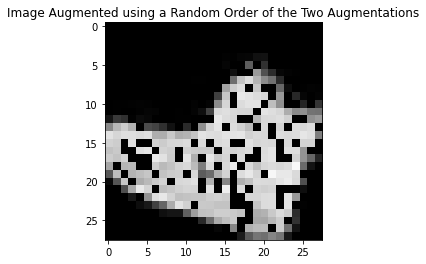

In [229]:
plt.imshow(seq.augment_image(test_image), cmap='gray', vmin=0, vmax=255)
plt.title('Image Augmented using a Random Order of the Two Augmentations')

### Data Augmentation on a Batch of Images

In [230]:
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x': (-10, 10)}, mode = 'constant')
])

#### Augmenting one image at a time


```python
%%time
for i in range(32):
    aug.augment_image(test_image)
```



#### Augmenting 32 images as a batch in one go


```python
%%time
aug.augment_image(tr_images[:32].cpu().detach().numpy())
```



#### Function collate_fn

In [231]:
class FMNISTDatasetCollate(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x, y
    def __len__(self): return len(self.x)

    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))
        # transform a batch of images at once
        if self.aug: ims=self.aug.augment_images(images=ims)
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims, classes

In [232]:
train = FMNISTDatasetCollate(tr_images, tr_targets, aug=aug)

trn_dl = DataLoader(train, batch_size = 64, 
                    collate_fn = train.collate_fn, shuffle = True)

In [233]:
val = FMNISTDatasetCollate(val_images, val_targets)

val_dl = DataLoader(val, batch_size = len(val_images),
                    collate_fn = val.collate_fn, shuffle = True)

In [234]:
model, loss, optimizer = get_model()

In [239]:
# for epoch in range(5):
#     print(epoch)
#     for ix, batch in enumerate(iter(trn_dl)):
#         x, y = batch
#         batch_loss = train_batch(x, y, model, optimizer, loss)

0


AttributeError: ignored

In [ ]:
# preds = []
# ix = 24300
# for px in range(-5,6):
#     img = tr_images[ix]/255.
#     img = img.view(28, 28)
#     img2 = np.roll(img, px, axis=1)
#     plt.imshow(img2)
#     plt.show()
#     img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
#     np_output = model(img3).cpu().detach().numpy()
#     preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(12,10))
# plt.title('Probability of each class \
# for various translations')
# sns.heatmap(np.array(preds).reshape(11,10), annot=True, \
#             ax=ax, fmt='.2f', xticklabels=fmnist.classes, \
#             yticklabels=[str(i)+str(' pixels') \
#                          for i in range(-5,6)], cmap='gray')

## Feature Learning

In [ ]:
!wget https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
!unzip all.zip

In [241]:
tfm = iaa.Sequential(iaa.Resize(28))

In [245]:
# Example
cv2.imread('/content/all/o@123Marker@uPRpUO.png')[:,:,0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [246]:
class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self): return len(self.files)
    
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:,:,0])
        im = im[None]
        # f is the hole path, as seen in the example above
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im / 255).to(device).float(), \
                    torch.tensor([cl]).float().to(device)

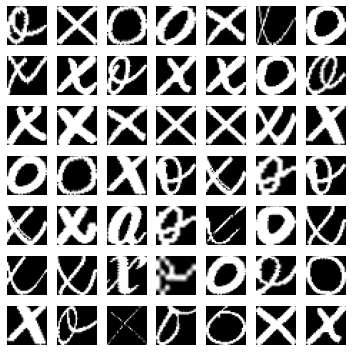

In [248]:
data = XO('/content/all/*')
R, C = 7, 7
fig, ax = plt.subplots(R, C, figsize=(5, 5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(100)
        im, label = data[ix]
        plot_cell.imshow(im[0].cpu(), cmap='gray')
plt.tight_layout()

In [249]:
def get_model():
    model = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(3200, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid()
            ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [250]:
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 1]                   257
├─Sigmoid: 1-11                          [-1, 1]                   --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass s

In [251]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct[0]

In [252]:
trn_dl = DataLoader(XO('/content/all/*'), batch_size=32,
                    drop_last=True)

In [254]:
for epoch in range(5):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

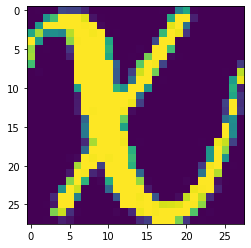

In [256]:
im, c = trn_dl.dataset[5]
plt.imshow(im[0].cpu())
plt.show()

In [260]:
# Pass the image through the trained model and fetch the 
# output of the first layer
first_layer = nn.Sequential(*list(model.children())[:1])
print(first_layer)
intermediate_output = first_layer(im[None])[0].detach()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
)


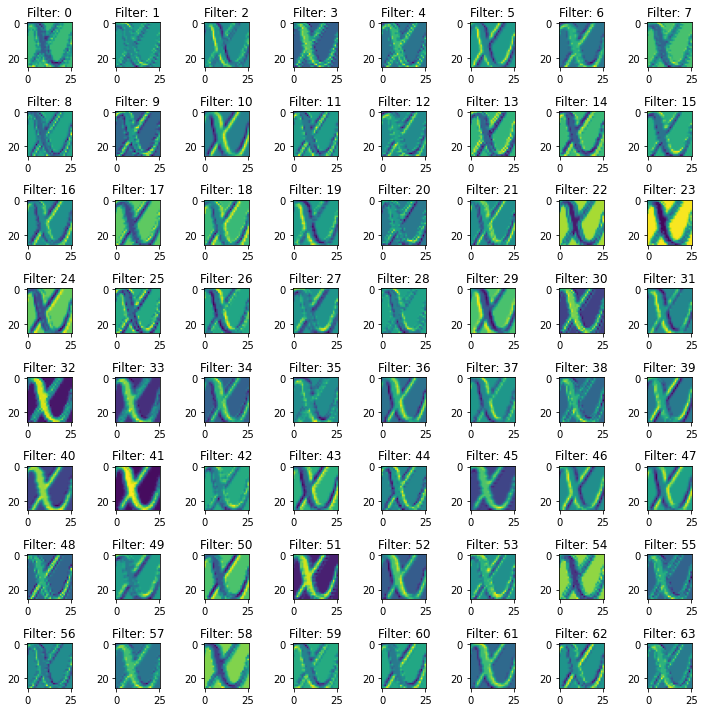

In [258]:
fig, ax = plt.subplots(8, 8, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

In [264]:
x, y = next(iter(trn_dl))
x2 = x[y != 0]

In [275]:
list(model.children())

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3200, out_features=256, bias=True),
 ReLU(),
 Linear(in_features=256, out_features=1, bias=True),
 Sigmoid()]

In [276]:
print(f'First Layer: \n {list(model.children())[:1]}')

First Layer: 
 [Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))]


In [265]:
x2 = x2.view(-1, 1, 28, 28)
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

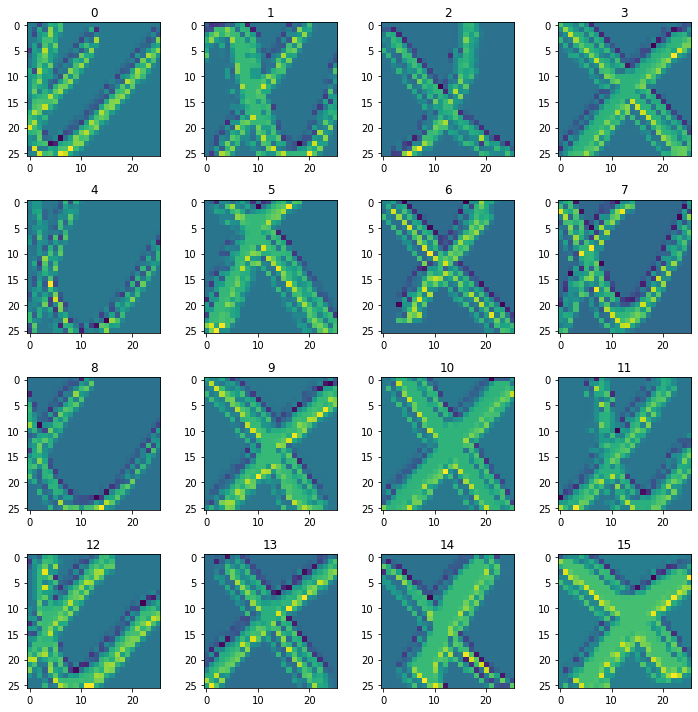

In [266]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(first_layer_output[ix,4,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

## Extracting until the second layer

In [277]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output=second_layer(im[None])[0].detach()

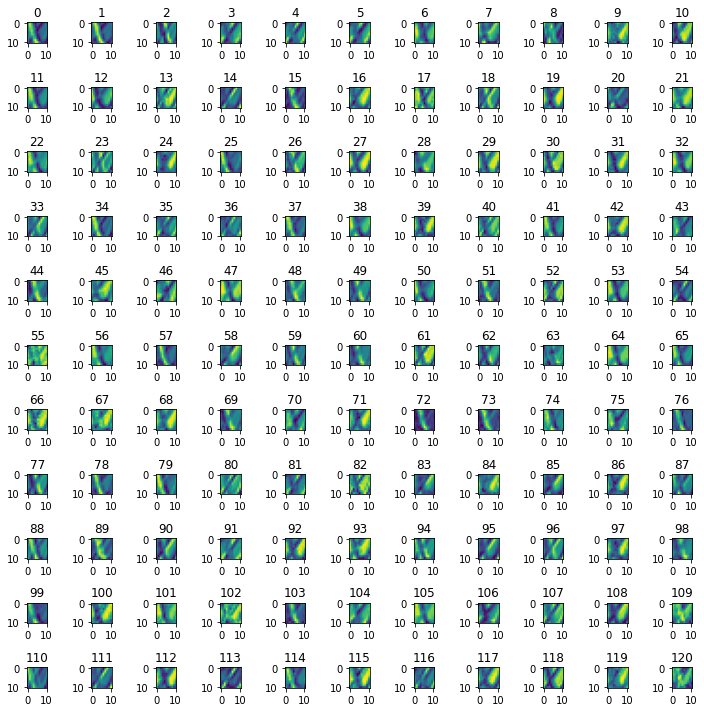

In [278]:
fig, ax = plt.subplots(11, 11, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

- Now, let's use the 34th filter's output in the preceding image as an example. When we pass multiple X images through filter 34, we should see similar activations across images

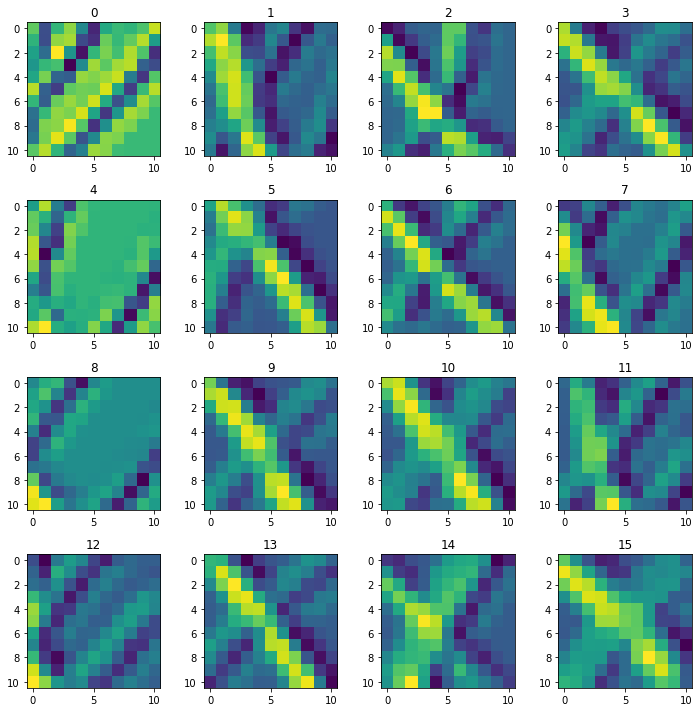

In [279]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(x2).detach()
fig, ax = plt.subplots(4, 4, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix,34,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

## Plotting the Activations of a Fully Connected Layer

In [280]:
custom_dl = DataLoader(XO('/content/all/*'), batch_size=2498,
                       drop_last=True)

In [281]:
x, y = next(iter(custom_dl))
x2 = x[y != 0]
x2 = x2.view(len(x2),1,28,28)

In [282]:
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

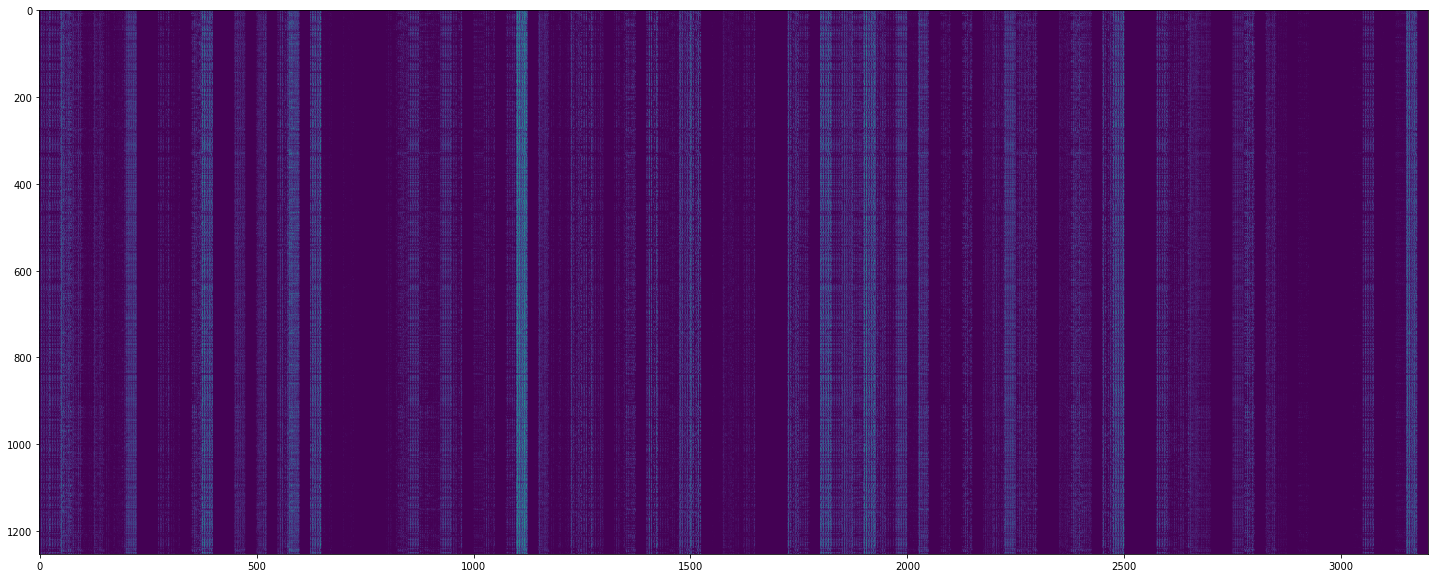

In [283]:
plt.figure(figsize=(100,10))
plt.imshow(flatten_layer_output.cpu())